# Temperature Profiling of 2D heat distribution

### In 2D, the temperature distribution across an area is governed by
$$
\frac{\partial T(x, y, t)}{\partial t} = \alpha \left( \frac{\partial^2 T(x, y, t)}{\partial x^2} + \frac{\partial^2 T(x, y, t)}{\partial y^2} \right)
$$
### Assuming $T(t,0,0) = T(t,L,L) = 0$ on a square $[0,L]\times[0,L] $ domain, the solutions are:
$$
T(x, y, t) = \sum_{n=1}^\infty \sum_{m=1}^\infty c_n c_m \sin\left(\frac{n\pi x}{L}\right) \sin\left(\frac{m\pi y}{L}\right) \exp\left(-\alpha t \left(\frac{n^2 \pi^2}{L^2} + \frac{m^2 \pi^2}{L^2}\right)\right)
$$
### For simplicity, let's define: $k_{nm} = \frac{n^2 \pi^2}{L^2} + \frac{m^2 \pi^2}{L^2}$
$$
T(x, y, t) = \sum_{n=1}^\infty \sum_{m=1}^\infty c_n c_m \sin\left(\frac{n\pi x}{L}\right) \sin\left(\frac{m\pi y}{L}\right) \exp\left(-\alpha  t  k_{nm}\right)
$$

## Covariance of initial coefficients (prior belief):
- ### lets map the coefficients $c_s, c_{s'}$ to a single label  $k = (s,s')$
- ### let $M_{k} = M_{ss'} =\frac{s^{2}\pi^2+(s')^2\pi^2}{L^2}$
- ### Let $g_{k}(t=0)  = g_{ss'}(t=0) = c_s c_{s'} \exp\left(-\alpha t [M_{ss'}]\right)$

### We assume no correlation:
$$
Cov(g_{k}(t),g_{r}(t))  = Cov(g_{ss'}(t),g_{ll'}(t)) = \delta_{ss'} \delta_{ll'} \sigma^2 
$$
### The covariance of coefficients at time $t$ is given by:
$$
\begin{align}
Cov(g_{k}(t),g_{r}(t)) &= Cov(g_{k}(0)e^{-\alpha t M_{k}},g_{r}(0)e^{-\alpha t M_{r}})\\
&=  e^{-\alpha t (  M_{k} + M_{r} )} Cov(g_{k}(0), g_{r}(0))\\
e^{+\alpha t (  M_{k} + M_{r} )} Cov(g_{k}(t),g_{r}(t)) &=Cov(g_{k}(0), g_{r}(0))
\end{align}
$$
### combining the above result and the assumption of no correlation:
$$
\begin{align}
Cov(g_{k}(0), g_{r}(0)) &= e^{+\alpha t (  M_{k} + M_{r} )} Cov(g_{k}(t),g_{r}(t)) \\
Cov(g_{k}(0), g_{r}(0)) &= e^{+\alpha t (  M_{k} + M_{r} )}\delta_{kr} \sigma^2 = e^{+\alpha t (  M_{k} + M_{r} )}\delta_{ss'} \delta_{ll'}\sigma^2  
\end{align}
$$

### The covariance matrix over the coeffecicents $c_{nm}$ should now be $n \times m$ because there are m combinations for each n. let $s = n \times m$, the matrix is given by:
$$
A_{s,s'} = e^{\alpha \left( k_s \right) t} \delta_{s,s'}
$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng(42)

def prior_covar(time: float,
                N_modes: int, 
                alpha: float,
                Length_x: float) -> np.ndarray:
    """
    Calculates the diagonal prior covariance matrix A explicitly. Assume square domain
        A_{(nm)(nm)} = exp(+alpha * t * [(n*pi/Lx)^2 + (m*pi/Ly)^2])
    Returns a full diagonal matrix of size (Nn*Nm) x (Nn*Nm).
    Uses (n+1) and (m+1) convention for modes matching basis functions.
    """
    t = time
    a = alpha
    modes_n = np.arange(1, N_modes + 1)
    modes_m = np.arange(1, N_modes + 1)

    kx_sq = (modes_n * np.pi / Length_x)**2
    ky_sq = (modes_m * np.pi / Length_x)**2
    k_nm_sq = kx_sq[:, None] + ky_sq[None, :] # Shape (Nn, Nm)

    # Calculate diagonal elements of A (positive exponent)
    A_diag_2d = np.exp(2*a * t * k_nm_sq) # Note the positive sign here

    # Flatten and create the full diagonal matrix
    A_diag_flat = A_diag_2d.flatten()
    A = np.diag(A_diag_flat)

    return A

def inv_prior_covar(A: np.ndarray) -> np.ndarray:
    """
    Calculates the diagonal elements of the inverse of a diagonal matrix A.
    Efficiently computes 1 / A[i, i].
    """
    # Extract the diagonal elements of A
    diag_A = np.diag(A)
    A_inv_diag = np.divide(1.0, diag_A, out=np.zeros_like(diag_A), where=diag_A!=0)
    # Alternatively:
    # epsilon = 1e-100 # A very small number to prevent division by zero
    # A_inv_diag = 1.0 / (diag_A + epsilon)

    return A_inv_diag

# Example
t= 0
a = 0.01
modes = 2
L = 1
print(prior_covar(t,modes, a, L))

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


### The Kernel function is a heuristic  function  which represents how function values at different points are correlated and fully encodes our prior information. For the 2D case, the kernel function captures the correlation between $x_1$ and $x_2$ and $x_1'$ and $x_2'$, so the intputs to the kernel function are $\mathit{X} = [x_1,x_2]$ and $\mathit{X'} = [x_1,x_2]$:
$$
\begin{align}
K(\mathit{X},\mathit{X'}) &= K((x_1,x_2), (x_1',x_2'))\\
&= \sum_{m=1}^N\sum_{n=1}^{N} A^{-1}_{s,s'} \sin(\frac{n\pi x_1}{L})\sin(\frac{m\pi x_2}{L})\sin(\frac{n\pi x_1'}{L})\sin(\frac{m\pi x_2'}{L})\\

&= \sum_{m=1}^N\sum_{n=1}^{N} A^{-1}_{n\times m,n\times m} \sin(\frac{n\pi x_1}{L})\sin(\frac{m\pi x_2}{L})\sin(\frac{n\pi x_1'}{L})\sin(\frac{m\pi x_2'}{L})

\end{align}
$$

### Compute the covariance matrix of the training data. 
### Let $\mathit{X} = [x_1,x_2], \mathit{X'} = [x_1',x_2']$
$$
\begin{align}

\bar{K}_{i,j} &= K(\mathit{X} , \mathit{X'}) + \sigma^2\delta_{i,j}\\
              &= K((x_i, x_i), (x_j', x_j')) + \sigma^2\delta_{i,j}
\end{align}
$$

In [2]:
import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng(42)

def kernel_function(Lx: float,
                     N_modes: int,
                     x1: float, 
                     x2: float,
                     x1_p: float,
                     x2_p: float,
                     A_inv_diag: np.ndarray)-> float:
    ''' 
    Computes kernel function at time t: 
        K((x1,x1'),(x2,x2')) = \sum_n \sum_m A^{-1}_{(nm),(nm)'} B_n(x_1) B_m(x_2) B_m(x_1') B_m(x_2') 
        B_n(x1) = sin(n pi x1/L) 
    '''
    N = N_modes
    M = N_modes # Assuming N=M often
    modes_n = np.arange(1, N + 1)
    modes_m = np.arange(1, M + 1)
    kx = modes_n * np.pi / Lx
    ky = modes_m * np.pi / Lx

    # Precompute sine terms
    sin_nx1  = np.sin(kx * x1)    # Shape (N,)
    sin_mx2  = np.sin(ky * x2)    # Shape (M,)
    sin_nx1p = np.sin(kx * x1_p)  # Shape (N,)
    sin_mx2p = np.sin(ky * x2_p)  # Shape (M,)

    # Combine spatial basis functions using outer product
    basis_xy  = np.outer(sin_nx1, sin_mx2)    # Shape (N, M)
    basis_xyp = np.outer(sin_nx1p, sin_mx2p)  # Shape (N, M)

    # Reshape A_inv_diag if it's flat
    A_inv_diag_2d = A_inv_diag.reshape((N, M)) # Shape (N, M)

    # Compute kernel by summing element-wise product
    kernel: float = np.sum(A_inv_diag_2d * basis_xy * basis_xyp)

    return kernel

def kernel_matrix(Lx: float,
                     N_modes: int,
                     x1_pts: np.ndarray, 
                     x2_pts: np.ndarray, 
                     A_inv_diag: np.ndarray 
                     ) -> np.ndarray:
    """
    Computes the MxM kernel matrix K[a, b] using vectorization (einsum).\n
    M is the number of measurement points.\n
    Point 'a' is (x1_pts[a], x2_pts[a]).\n
    Point 'b' is (x1_pts[b], x2_pts[b]).\n
    K[a, b] = K((x1_a, x2_a), (x1_b, x2_b))
            = Σ_n Σ_m A⁻¹_{(nm)(nm)} * [sin(k_nx*x1_a)sin(k_my*x2_a)] * [sin(k_nx*x1_b)sin(k_my*x2_b)]
    """
    N,M = N_modes, N_modes # Assuming square grid of modes (Nn=Nm=N)
    modes_n, modes_m = np.arange(1, N + 1), np.arange(1, M + 1)
    kx,ky = modes_n * np.pi / Lx, modes_m * np.pi / Lx
    A_inv_diag_2d = A_inv_diag.reshape((N, M)) # Index 'nm'
    # print(A_inv_diag_2d)
    # Calculate sine terms evaluated at all points for all modes
    sin_nx_pts = np.sin(np.outer(x1_pts, kx)) 
    sin_my_pts = np.sin(np.outer(x2_pts, ky)) 

    # Compute the kernel matrix K[a, b] using einsum
    kernel_mat = np.einsum('nm,an,am,bn,bm->ab',
                           A_inv_diag_2d,
                           sin_nx_pts, sin_my_pts,
                           sin_nx_pts, sin_my_pts, # Use same arrays for point b
                           optimize='optimal')
    return kernel_mat

Calculating MxM Kernel Matrix...


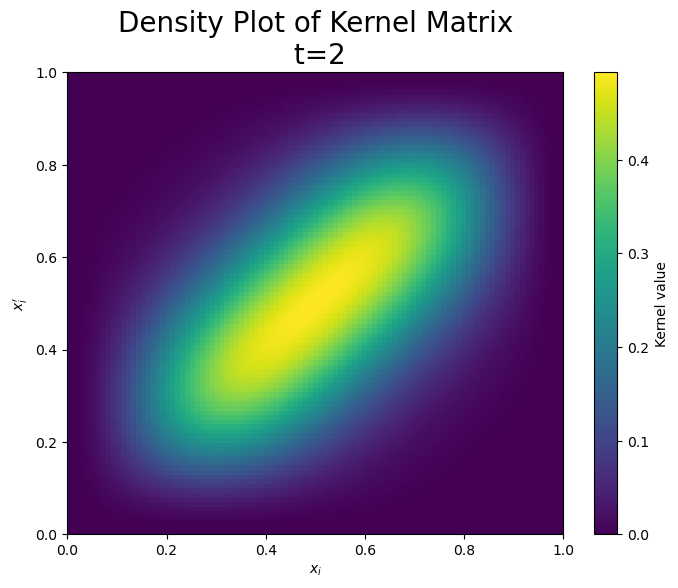

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
rng = np.random.default_rng(1) #

# Parameters
# time = 0
L = 1.0
alpha = 0.01
modes = 5
sigma = 0.01
divisions = 100
x_step = L / divisions
X_array = np.arange(0, L + x_step, x_step)

time_list = [0,0.25,0.5,0.75,1,2]
for time in time_list:
    A = prior_covar(time,modes, alpha, L)
    A_inv_diag = inv_prior_covar(A)

# Calculate the MxM kernel matrix
print("Calculating MxM Kernel Matrix...")
kernel = kernel_matrix(L, modes, X_array, X_array, A_inv_diag)
plt.figure(figsize=(8, 6))
plt.imshow(kernel,extent=(0, L, 0, L), origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(label="Kernel value")
plt.title(f"Density Plot of Kernel Matrix\n t={time}",size=20)
plt.xlabel(r"$x_i$")
plt.ylabel(r"$x_i'$")
plt.show()

### The mean prediction is given by:
$$
\begin{align}
\langle T(\mathit{X}) \rangle &= \langle T((x_i, x_i)) \rangle \\
                                           &= \sum_{i,j} K((x,x_j), (x',x_l'))\bar{K}_{i,j}^{-1} T_{j} 
\end{align}
$$
### Here, $T_j$ represents the temperature measurement: $T_j =T(t,(x_j,x_j') ) $. The Variance is given by:
$$
\begin{align}
\sigma_{\text{post}}^2(\mathit{X}) &=  K(\mathit{X},\mathit{X} ) + \sum_{i,j} K(\mathit{X},\mathit{X_i'}) \bar{K}_{i,j}^{-1}K(\mathit{X_j},\mathit{X'})\\

\sigma_{\text{post}}^2((x,x)) &=  K((x,x), (x,x)) + \sum_{i,j} K((x,x), (x,x)_i) \bar{K}_{i,j}^{-1}K((x,x)_j, (x,x))

\end{align}
$$

In [4]:
import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng(42)

def measure_T(diffuse: float,
              time: float,
              x_list: list, 
              xp_list: list, 
              Length_x: float,
              coeffs_x: np.ndarray,
              coeffs_y: np.ndarray) -> np.ndarray:
    """
    measures temperatures T(x, y) at specified points,
    where x = x_list[k] and y = xp_list[k] for each index k.
    """
    # Ensure inputs are numpy arrays
    x_pts = np.asarray(x_list)
    y_pts = np.asarray(xp_list) # y coordinates come from xp_list

    Lx = Length_x
    Ly = Length_x 
    c_n = coeffs_x
    c_m = coeffs_y
    N = len(c_n) 

    modes = np.arange(1, N + 1) 
    kx = modes * np.pi / Lx
    ky = modes * np.pi / Ly

    # Calculate the separate exponential decay factors for each mode direction
    exp_decay_n = np.exp(-diffuse * time * kx**2) 
    exp_decay_m = np.exp(-diffuse * time * ky**2) 
    coeffs_combined = np.outer(c_n * exp_decay_n, c_m * exp_decay_m) # Shape (N, N)

    sin_nx_pts = np.sin(np.outer(x_pts, kx))
    sin_my_pts = np.sin(np.outer(y_pts, ky)) 
    temperature_at_points = np.einsum('nm,kn,km->k',
                                       coeffs_combined,
                                       sin_nx_pts,
                                       sin_my_pts,
                                       optimize='optimal')

    return temperature_at_points

def temp_distr_2d(diffuse: float,time: float,
                  Length_x: float, x_array: np.ndarray,
                  coeffs_x: np.ndarray, coeffs_y: np.ndarray) -> np.ndarray:
    ''' 
    Calculates the 2d temperature distribution on a plane
    '''
    Lx = Length_x
    Ly = Length_x
    y_array = x_array
    c_n = coeffs_x
    c_m = coeffs_y

    return sum(
        c_n[n] * c_m[m]
        * np.exp(-diffuse * time * (((n + 1) * np.pi / Lx) ** 2 + ((m + 1) * np.pi / Ly) ** 2))
        * np.sin((n + 1) * np.pi * x_array / Lx)[:, None]
        * np.sin((m + 1) * np.pi * y_array / Ly)[None, :]
        for n in range(len(c_n))
        for m in range(len(c_m))
    )

def prior_covar(time: float,
                N_modes: int, 
                alpha: float,
                Length_x: float) -> np.ndarray:
    """
    Calculates the diagonal prior covariance matrix A explicitly. Assume square domain
        A_{(nm)(nm)} = exp(+alpha * t * [(n*pi/Lx)^2 + (m*pi/Ly)^2])
    Returns a full diagonal matrix of size (Nn*Nm) x (Nn*Nm).
    Uses (n+1) and (m+1) convention for modes matching basis functions.
    """
    t = time
    a = alpha
    modes_n = np.arange(1, N_modes + 1)
    modes_m = np.arange(1, N_modes + 1)

    kx_sq = (modes_n * np.pi / Length_x)**2
    ky_sq = (modes_m * np.pi / Length_x)**2
    k_nm_sq = kx_sq[:, None] + ky_sq[None, :] # Shape (Nn, Nm)

    # Calculate diagonal elements of A (positive exponent)
    A_diag_2d = np.exp(a * t * k_nm_sq) # Note the positive sign here

    # Flatten and create the full diagonal matrix
    A_diag_flat = A_diag_2d.flatten()
    A = np.diag(A_diag_flat)

    return A

def inv_prior_covar(A: np.ndarray) -> np.ndarray:
    """
    Calculates the diagonal elements of the inverse of a diagonal matrix A.
    Efficiently computes 1 / A[i, i].
    """
    # Extract the diagonal elements of A
    diag_A = np.diag(A)
    A_inv_diag = np.divide(1.0, diag_A, out=np.zeros_like(diag_A), where=diag_A!=0)
    # Alternatively:
    # epsilon = 1e-100 # A very small number to prevent division by zero
    # A_inv_diag = 1.0 / (diag_A + epsilon)

    return A_inv_diag

def inv_covar(time: float,
            N_modes: int,
            alpha: float,
            Length_x: float) -> np.ndarray:
    """
    Calculates the diagonal elements of the *inverse* of the prior covariance matrix A (A_inv_diag).
    This corresponds to the prior variance of the coefficients in the GPR kernel construction.

    Assumes A had diagonal elements:
        A_{(nm)(nm)} = exp(+alpha * t * [(n*pi/Lx)^2 + (m*pi/Ly)^2])
    Therefore, the diagonal elements of A_inv are:
        A_inv_{(nm)(nm)} = exp(-alpha * t * [(n*pi/Lx)^2 + (m*pi/Ly)^2])
    """
    t = time
    a = alpha


    Length_y = Length_x

    # Define mode indices (start from 1 as per convention noted)
    modes_n = np.arange(1, N_modes + 1)
    modes_m = np.arange(1, N_modes + 1)

    # Calculate squared wavenumbers
    kx_sq = (modes_n * np.pi / Length_x)**2
    ky_sq = (modes_m * np.pi / Length_y)**2 # Use Length_y here

    # Create a 2D grid of the sum of squared wavenumbers
    # k_nm_sq[n-1, m-1] corresponds to mode (n, m)
    k_nm_sq = kx_sq[:, None] + ky_sq[None, :] # Shape (N_modes, N_modes)

    # Calculate diagonal elements of A_inv directly using NEGATIVE exponent
    # This avoids overflow as the exponent will be negative or zero
    A_inv_diag_2d = np.exp(-a * t * k_nm_sq)

    # Flatten the 2D array of diagonal elements into a 1D array
    A_inv_diag_flat = A_inv_diag_2d.flatten()

    return A_inv_diag_flat

def kernel_function(Lx: float,
                     N_modes: int,
                     x1: float, 
                     x2: float,
                     x1_p: float,
                     x2_p: float,
                     A_inv_diag: np.ndarray)-> float:
    ''' 
    Computes kernel function at time t: 
        K((x1,x1'),(x2,x2')) = \sum_n \sum_m A^{-1}_{(nm),(nm)'} B_n(x_1) B_m(x_2) B_m(x_1') B_m(x_2') 
        B_n(x1) = sin(n pi x1/L) 
    '''
    N = N_modes
    M = N_modes # Assuming N=M often
    modes_n = np.arange(1, N + 1)
    modes_m = np.arange(1, M + 1)
    kx = modes_n * np.pi / Lx
    ky = modes_m * np.pi / Lx

    # Precompute sine terms
    sin_nx1  = np.sin(kx * x1)    # Shape (N,)
    sin_mx2  = np.sin(ky * x2)    # Shape (M,)
    sin_nx1p = np.sin(kx * x1_p)  # Shape (N,)
    sin_mx2p = np.sin(ky * x2_p)  # Shape (M,)

    # Combine spatial basis functions using outer product
    basis_xy  = np.outer(sin_nx1, sin_mx2)    # Shape (N, M)
    basis_xyp = np.outer(sin_nx1p, sin_mx2p)  # Shape (N, M)

    # Reshape A_inv_diag if it's flat
    A_inv_diag_2d = A_inv_diag.reshape((N, M)) # Shape (N, M)

    # Compute kernel by summing element-wise product
    kernel: float = np.sum(A_inv_diag_2d * basis_xy * basis_xyp)

    return kernel

def kernel_matrix(Lx: float,
                     N_modes: int,
                     x1_pts: np.ndarray, 
                     x2_pts: np.ndarray, 
                     A_inv_diag: np.ndarray 
                     ) -> np.ndarray:
    """
    Computes the MxM kernel matrix K[a, b] using vectorization (einsum).\n
    M is the number of measurement points.\n
    Point 'a' is (x1_pts[a], x2_pts[a]).\n
    Point 'b' is (x1_pts[b], x2_pts[b]).\n
    K[a, b] = K((x1_a, x2_a), (x1_b, x2_b))
            = Σ_n Σ_m A⁻¹_{(nm)(nm)} * [sin(k_nx*x1_a)sin(k_my*x2_a)] * [sin(k_nx*x1_b)sin(k_my*x2_b)]
    """
    N,M = N_modes, N_modes # Assuming square grid of modes (Nn=Nm=N)
    modes_n, modes_m = np.arange(1, N + 1), np.arange(1, M + 1)
    kx,ky = modes_n * np.pi / Lx, modes_m * np.pi / Lx
    A_inv_diag_2d = A_inv_diag.reshape((N, M)) # Index 'nm'

    # Calculate sine terms evaluated at all points for all modes
    sin_nx_pts = np.sin(np.outer(x1_pts, kx)) 
    sin_my_pts = np.sin(np.outer(x2_pts, ky)) 

    # Compute the kernel matrix K[a, b] using einsum
    kernel_mat = np.einsum('nm,an,am,bn,bm->ab',
                           A_inv_diag_2d,
                           sin_nx_pts, sin_my_pts,
                           sin_nx_pts, sin_my_pts, # Use same arrays for point b
                           optimize='optimal')
    return kernel_mat

def data_covar(Lx: float,
                  N_modes_n: int, 
                  x1_measured: np.ndarray, 
                  x2_measured: np.ndarray, 
                  A_inv_diag: np.ndarray,
                  sigma: float,
                  kernel_func_2d: callable) -> np.ndarray:
    """
    Builds the M x M covariance matrix Kbar for the 2D measurement points.
    Kbar[a, b] = K((x1_a, x2_a), (x1_b, x2_b)) + sigma^2 * delta_ab
    """
    M = len(x1_measured)
    Kbar_base = np.zeros((M, M))
    for a in range(M):
        for b in range(M):
            Kbar_base[a, b] = kernel_func_2d(Lx, N_modes_n,
                                            x1_measured[a], x2_measured[a], # Point a (x, y)
                                            x1_measured[b], x2_measured[b], # Point b (x', y')
                                            A_inv_diag)

    Kbar: np.ndarray = Kbar_base + (sigma**2) * np.eye(M)
    return Kbar

def mean_prediction(x1_pred: float,
                       x2_pred: float,
                       Lx: float, 
                       N_modes: int,
                       A_inv_diag: np.ndarray,
                       kernel_func_2d: callable,
                       Kbar_MM_inv: np.ndarray, # MxM Inverse Covariance Matrix
                       x1_measured: np.ndarray, x2_measured: np.ndarray,
                       T_measured: np.ndarray) -> float:
    """
    Calculates the GPR mean prediction at a 2D point (x1_pred, x2_pred).
    """
    M = len(x1_measured)

    # 1. Calculate the vector K_pred (correlations between pred point and measured points)
    K_pred_vec = np.zeros(M)
    for a in range(M):
        K_pred_vec[a] = kernel_func_2d(Lx, N_modes,
                                       x1_pred, x2_pred,             # Prediction point (x, y)
                                       x1_measured[a], x2_measured[a], # Measurement point a (x', y')
                                       A_inv_diag)

    # 2. Calculate Kbar_MM_inv @ T_measured
    weights = Kbar_MM_inv @ T_measured
    mean_pred = K_pred_vec @ weights

    return mean_pred

def mean_prediction_matrix(x_pred_grid: np.ndarray, # 1D array of x prediction coords
                            y_pred_grid: np.ndarray, # 1D array of y prediction coords
                            Lx: float,
                            N_modes_n: int,
                            A_inv_diag: np.ndarray,
                            Kbar_MM_inv: np.ndarray, # MxM Inverse Covariance Matrix
                            x1_measured: np.ndarray, # x-coordinates of M points
                            x2_measured: np.ndarray, # y-coordinates of M points
                            T_measured: np.ndarray) -> np.ndarray:
    """
    Calculates the GPR mean prediction for all points on a grid efficiently.
    """
    N = N_modes_n
    M = N_modes_n # Assuming N=M

    modes_n = np.arange(1, N + 1)
    modes_m = np.arange(1, M + 1)
    kx = modes_n * np.pi / Lx
    ky = modes_m * np.pi / Lx

    # Reshape A_inv_diag to (N, M_modes)
    A_inv_diag_2d = A_inv_diag.reshape((N, M)) # Index 'nm'

    # Precompute weights (constant for all predictions)
    weights = Kbar_MM_inv @ T_measured # Shape (M_meas,)

    # Precompute sine terms for ALL prediction points
    sin_nx_pred = np.sin(np.outer(x_pred_grid, kx))
    sin_my_pred = np.sin(np.outer(y_pred_grid, ky)) 

    # Precompute sine terms for ALL measurement points
    sin_nx_meas = np.sin(np.outer(x1_measured, kx)) 
    sin_my_meas = np.sin(np.outer(x2_measured, ky))

    # Compute the N_pred x M_meas kernel prediction matrix using einsum
    K_pred_all = np.einsum('nm,pn,pm,an,am->pa',
                           A_inv_diag_2d,
                           sin_nx_pred, sin_my_pred,
                           sin_nx_meas, sin_my_meas,
                           optimize='optimal') # Shape (N_pred, M_meas)

    # Calculate all mean predictions with a single matrix-vector product
    mean_pred_flat = K_pred_all @ weights # Shape (N_pred,)

    return mean_pred_flat

def diag_prior_covar(x_pred_flat: np.ndarray,
                                             y_pred_flat: np.ndarray,
                                             Lx: float,
                                             N_modes: int,
                                             A_inv_diag: np.ndarray) -> np.ndarray:
    """
    Calculates the prior variance K(x,x) for each point on the prediction grid using vectorization.
    K(x,x) = Sum_n Sum_m A_inv_nm * sin^2(n*pi*x1/L) * sin^2(m*pi*x2/L)
    """
    N = N_modes
    M = N_modes # Assuming square modes
    modes_n = np.arange(1, N + 1)
    modes_m = np.arange(1, M + 1)
    kx = modes_n * np.pi / Lx
    ky = modes_m * np.pi / Lx

    A_inv_diag_2d = A_inv_diag.reshape((N, M)) # Index 'nm'

    # Calculate sine terms for all prediction points
    sin_nx_pred_sq = np.sin(np.outer(x_pred_flat, kx))**2 # Shape (N_pred, N)
    sin_my_pred_sq = np.sin(np.outer(y_pred_flat, ky))**2 # Shape (N_pred, M)

    # Calculate K(x,x) for all points using einsum
    # We want Sum_n Sum_m A_inv_nm * sin_nx_p^2 * sin_my_p^2 for each point p
    K_xx_flat = np.einsum('nm,pn,pm->p',
                          A_inv_diag_2d,
                          sin_nx_pred_sq,
                          sin_my_pred_sq,
                          optimize='optimal') # Shape (N_pred,)
    return K_xx_flat

def vectorized_variance(x_pred_flat: np.ndarray,
                           y_pred_flat: np.ndarray,
                           Lx: float,
                           N_modes: int,
                           A_inv_diag: np.ndarray,
                           Kbar_inv: np.ndarray,   # Precomputed M x M inverse
                           x1_measured: np.ndarray,
                           x2_measured: np.ndarray,
                           grid_res: int, 
                           ) -> np.ndarray:
    """
    Calculates the GPR posterior variance over a 2D grid using vectorization.

    \sigma²_post(x) = K(x,x) - K(x, X)ᵀ K̄⁻¹ K(x, X)
    """

    # --- Step 1: Calculate K(x,x) for all prediction points ---
    K_xx_flat = diag_prior_covar(
         x_pred_flat, y_pred_flat, Lx, N_modes, A_inv_diag
    ) # Shape (N_pred,)

    # --- Step 2: Calculate K(x, X) matrix (N_pred x M_meas) ---
    N = N_modes; M = N_modes
    modes_n = np.arange(1, N + 1); modes_m = np.arange(1, M + 1)
    kx = modes_n * np.pi / Lx; ky = modes_m * np.pi / Lx
    A_inv_diag_2d = A_inv_diag.reshape((N, M))

    sin_nx_pred = np.sin(np.outer(x_pred_flat, kx)) # N_pred x N
    sin_my_pred = np.sin(np.outer(y_pred_flat, ky)) # N_pred x M
    sin_nx_meas = np.sin(np.outer(x1_measured, kx)) # M_meas x N
    sin_my_meas = np.sin(np.outer(x2_measured, ky)) # M_meas x M

    K_pred_measure = np.einsum('nm,pn,pm,an,am->pa', # pa means N_pred x M_meas
                               A_inv_diag_2d,
                               sin_nx_pred, sin_my_pred,
                               sin_nx_meas, sin_my_meas,
                               optimize='optimal') # Shape (N_pred, M_meas)


    # --- Step 3: Calculate the quadratic term K(x, X)ᵀ K̄⁻¹ K(x, X) ---
    Temp = K_pred_measure @ Kbar_inv # Shape (N_pred, M_meas)
    Quadratic_form_flat = np.sum(Temp * K_pred_measure, axis=1) # Shape (N_pred,)

    # --- Step 4: Calculate Posterior Variance ---
    Variance_flat = K_xx_flat - Quadratic_form_flat # Shape (N_pred,)

    # --- Step 5: Numerical Stability - Ensure non-negative variance ---
    Variance_flat = np.maximum(Variance_flat, 1e-18) # Set small floor instead of 0

    # --- Step 6: Reshape back to grid ---
    Variance_grid = Variance_flat.reshape((grid_res, grid_res))

    return Variance_grid

def plot_temperature_grid(ax, data_grid, x1_measure, x2_measure, measured_temps, extent, cmap, label, title, clim=None, scatter_color='viridis', scatter_edge='k', scatter_size=50):
    """
    Plots a temperature distribution on a given axis with associated scatter data.
    """
    im = ax.imshow(data_grid, extent=extent, origin='lower', cmap=cmap, aspect='auto', vmin=clim[0] if clim else None, vmax=clim[1] if clim else None)
    ax.scatter(x1_measure, x2_measure, c=measured_temps, cmap=scatter_color, edgecolor=scatter_edge, s=scatter_size, label='Measurements')
    ax.set_title(title, size=15)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    cbar = plt.colorbar(im, ax=ax, label=label, fraction=0.046, pad=0.04)
    ax.legend()
    return im

def plot_3d_temperature(ax, X, Y, Z, x_measure, y_measure, z_measure, title, xlabel, ylabel, zlabel, cmap, vmin=None, vmax=None, scatter_color='b', scatter_size=50, alpha=0.8):
    """
    Plots a 3D temperature distribution on a given axis with associated scatter data.
    """
    # Plot surface
    surf = ax.plot_surface(X, Y, Z, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha)
    
    # Scatter points for measurements
    if x_measure is not None and y_measure is not None and z_measure is not None:
        ax.scatter(x_measure, y_measure, z_measure, color=scatter_color, s=scatter_size, depthshade=True, label='Data')
    
    # Set labels and title
    ax.set_title(title, size=15)
    ax.set_xlabel(xlabel, size=12)
    ax.set_ylabel(ylabel, size=12)
    ax.set_zlabel(zlabel, size=12)
    
    # Add color bar
    cbar = plt.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)
    cbar.set_label(zlabel, size=12)
    
    # Add legend for scatter points
    ax.legend()
    
    return surf


## Solution

Prediction complete.
Variance calculation complete.
Plotting...
Prediction complete.
Variance calculation complete.
Plotting...
Prediction complete.
Variance calculation complete.
Plotting...
Prediction complete.
Variance calculation complete.
Plotting...


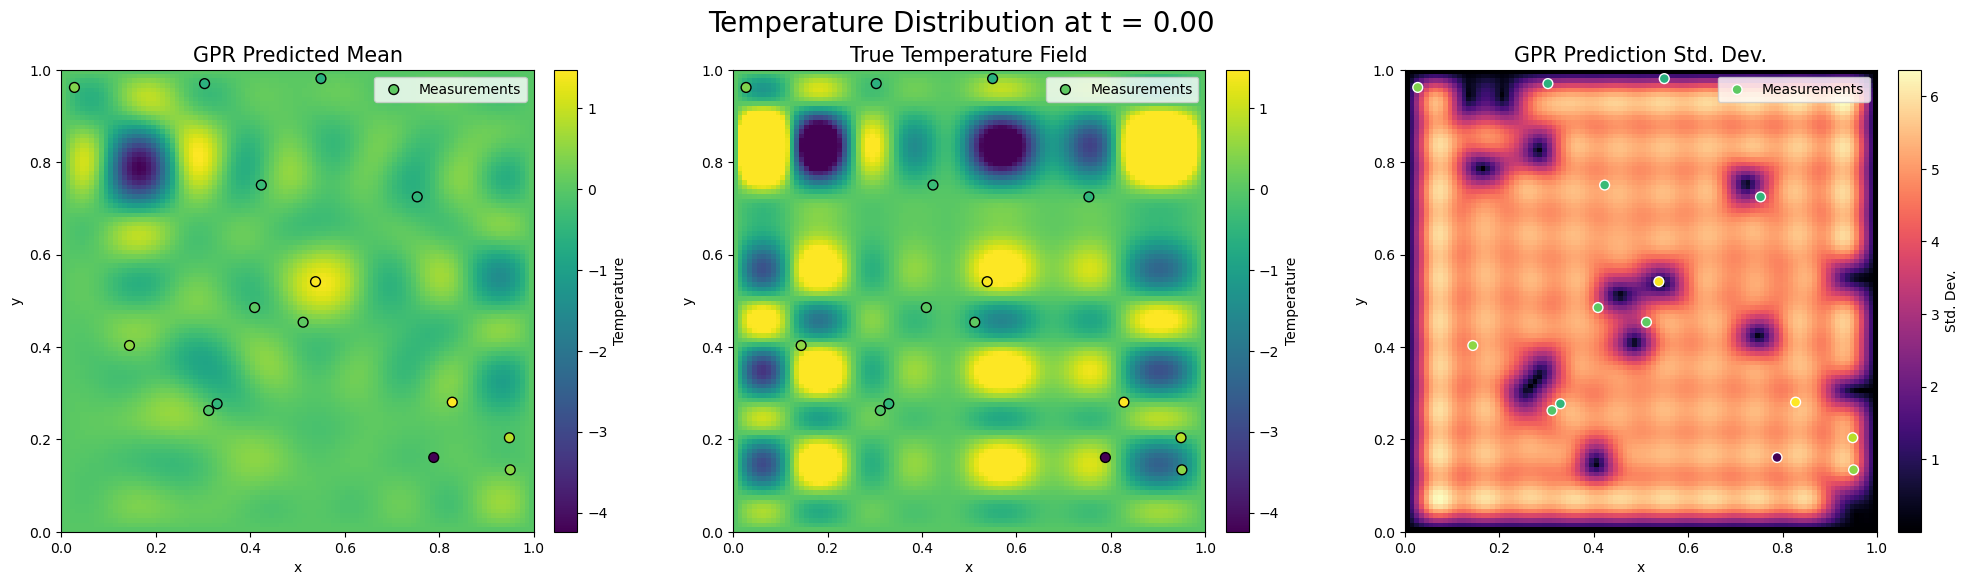

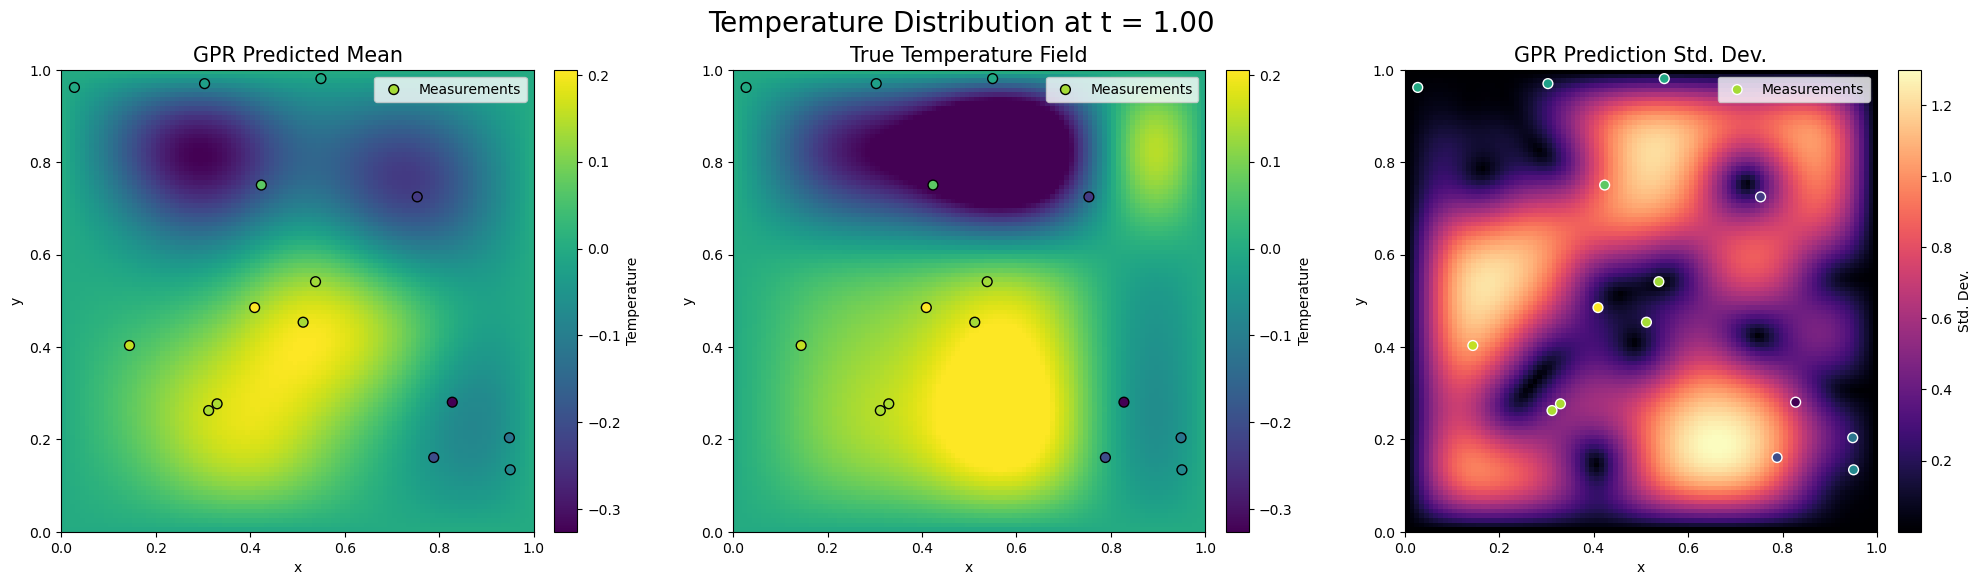

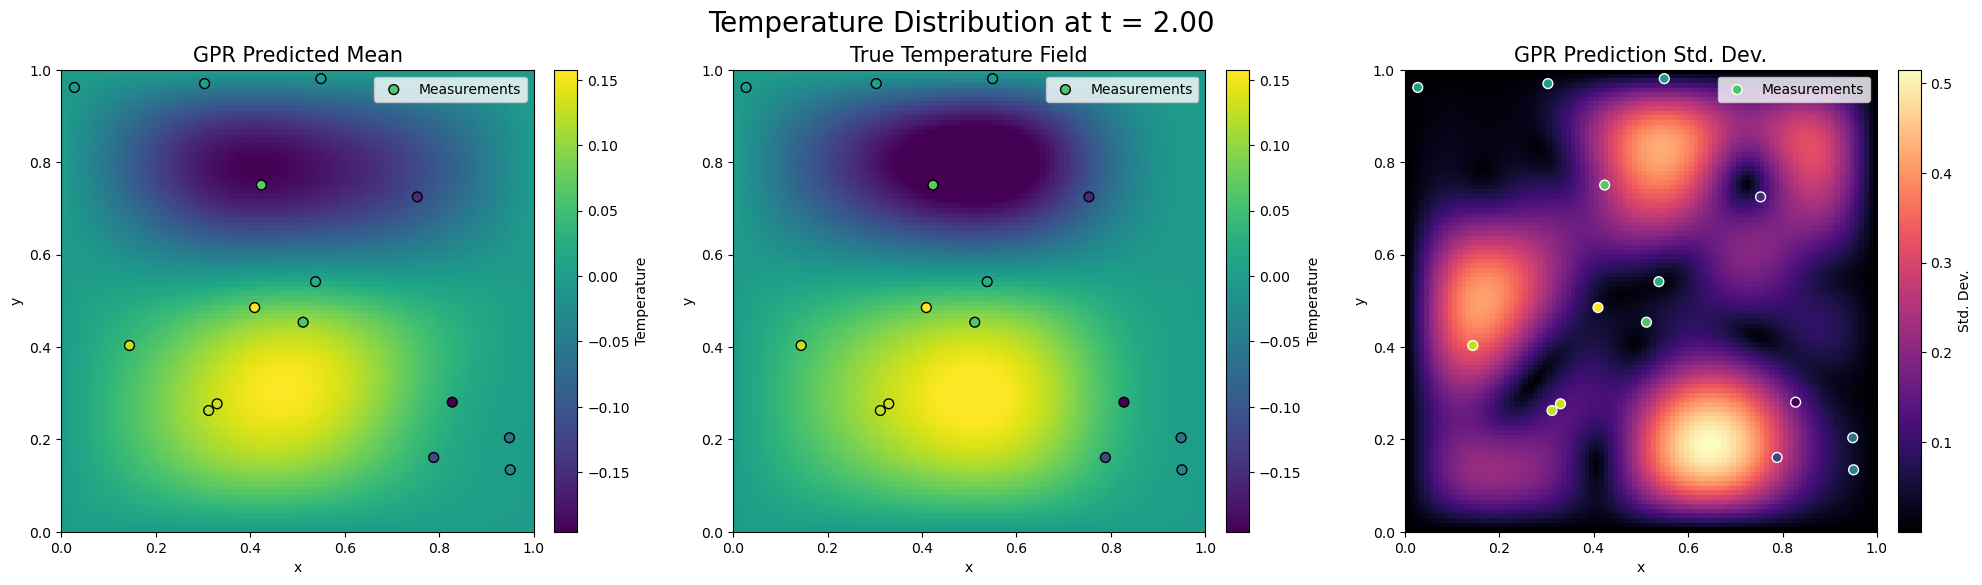

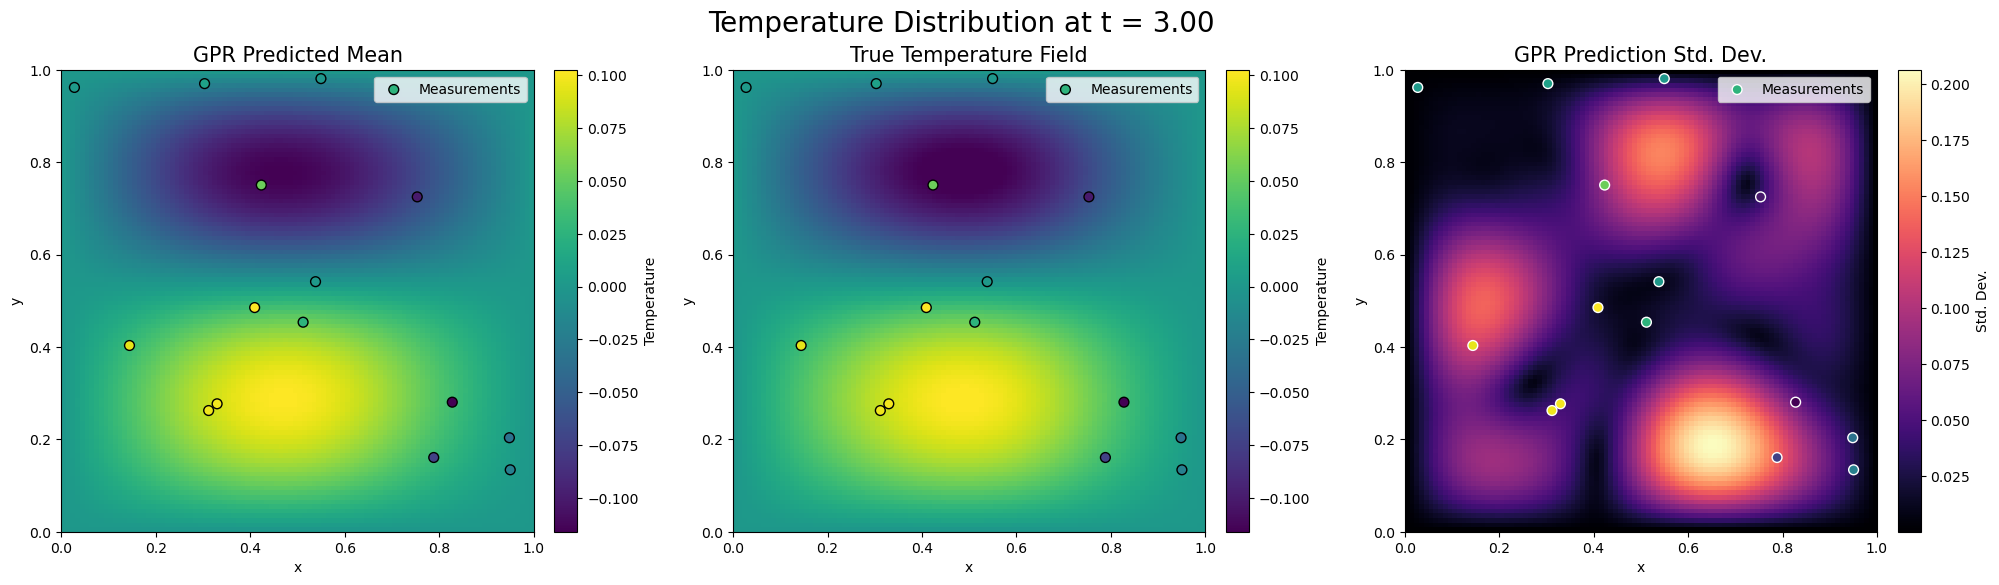

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
rng = np.random.default_rng(1) 

# --- Parameters ---
L = 1.0           # Assume square domain Lx = Ly = L
alpha = 0.01
modes = 10       # Use same number of modes in each direction for simplicity Nn = Nm = N
sigma = 0.01      # Measurement noise
grid_res = 100 # Resolution for plotting
num_meas = 15

# Generate random Fourier coefficients
c_n,c_m = rng.uniform(-1, 1, modes), rng.uniform(-1, 1, modes)

# Define Measurement Points (e.g., 5 points)
rng_measurements = np.random.default_rng(1)
x1_measure = rng_measurements.uniform(0, L, size=num_meas)
x2_measure = rng_measurements.uniform(0, L, size=num_meas)

# Define Prediction Grid
x_plot,y_plot = np.linspace(0, L, grid_res), np.linspace(0, L, grid_res)
X_plot, Y_plot = np.meshgrid(x_plot, y_plot)

# Flatten prediction grid coordinates
x_pred_flat = X_plot.flatten()
y_pred_flat = Y_plot.flatten()

# --- Time Loop for Plotting/Animation ---
time_list = [0, 1.0, 2.0,3.0] # Example times

for time in time_list:
    measured_temps = measure_T(alpha, time, x1_measure, x2_measure, L, c_n, c_m)
    A_inv_diag = inv_covar(time, modes, alpha, L)
    Kbar = data_covar(L, modes, x1_measure, x2_measure, A_inv_diag, sigma, kernel_function)
    Kbar_inv = linalg.inv(Kbar) 

    T_pred_flat = mean_prediction_matrix(
        x_pred_flat, y_pred_flat,
        L,  modes, A_inv_diag,
        Kbar_inv,
        x1_measure, x2_measure,
        measured_temps
    )

    # Reshape the flat prediction array back to the grid shape
    T_pred_grid = T_pred_flat.reshape((grid_res, grid_res))
    print("Prediction complete.")

    # --- Calculate Variance Grid ---
    Var_pred_grid = vectorized_variance(
        x_pred_flat, y_pred_flat,
        L, modes, A_inv_diag,
        Kbar_inv,
        x1_measure, x2_measure,
        grid_res
    )
    Std_dev_grid = np.sqrt(Var_pred_grid) # Standard deviation is often plotted
    print("Variance calculation complete.")

    T_true_grid = temp_distr_2d(alpha, time, L, x_plot, c_n, c_m)
    # --- Plotting ---
    print("Plotting...")
    fig, axes = plt.subplots(1, 3, figsize=(24, 6), gridspec_kw={'width_ratios': [1, 1, 1], 'wspace': 0.3})
    fig.suptitle(f"Temperature Distribution at t = {time:.2f}", size=20)

    extent = (0, L, 0, L)

    # Predicted Mean
    im0 = plot_temperature_grid(
        axes[0], T_pred_grid.T, x1_measure, x2_measure, measured_temps, extent,
        cmap='viridis', label="Temperature", title="GPR Predicted Mean"
    )

    # True Field
    im1 = plot_temperature_grid(
        axes[1], T_true_grid, x1_measure, x2_measure, measured_temps, extent,
        cmap='viridis', label="Temperature", title="True Temperature Field", clim=im0.get_clim()
    )

    # Standard Deviation
    im2 = plot_temperature_grid(
        axes[2], Std_dev_grid.T, x1_measure, x2_measure, measured_temps, extent,
        cmap='magma', label="Std. Dev.", title="GPR Prediction Std. Dev.",
        scatter_color=None, scatter_edge='w', scatter_size=50
    )



# 3D plots:

Prediction complete.
Variance calculation complete.
Plotting...


/tmp/ipykernel_860/3842431299.py:433: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


Prediction complete.
Variance calculation complete.
Plotting...
Prediction complete.
Variance calculation complete.
Plotting...
Prediction complete.
Variance calculation complete.
Plotting...


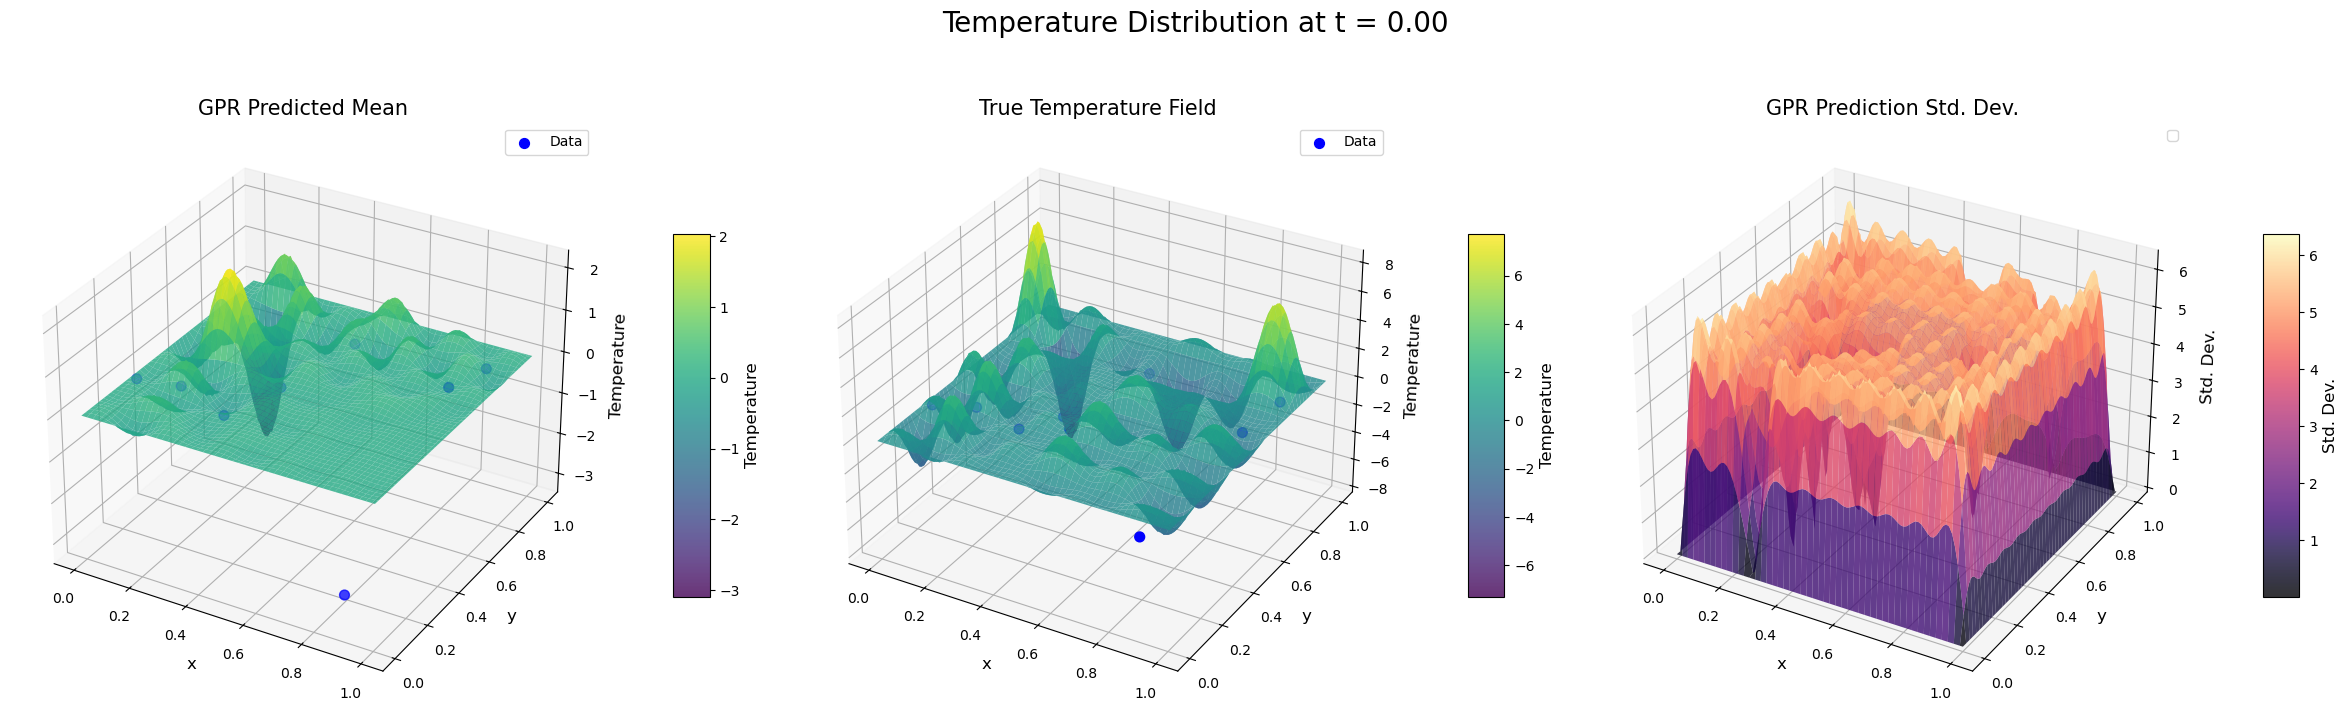

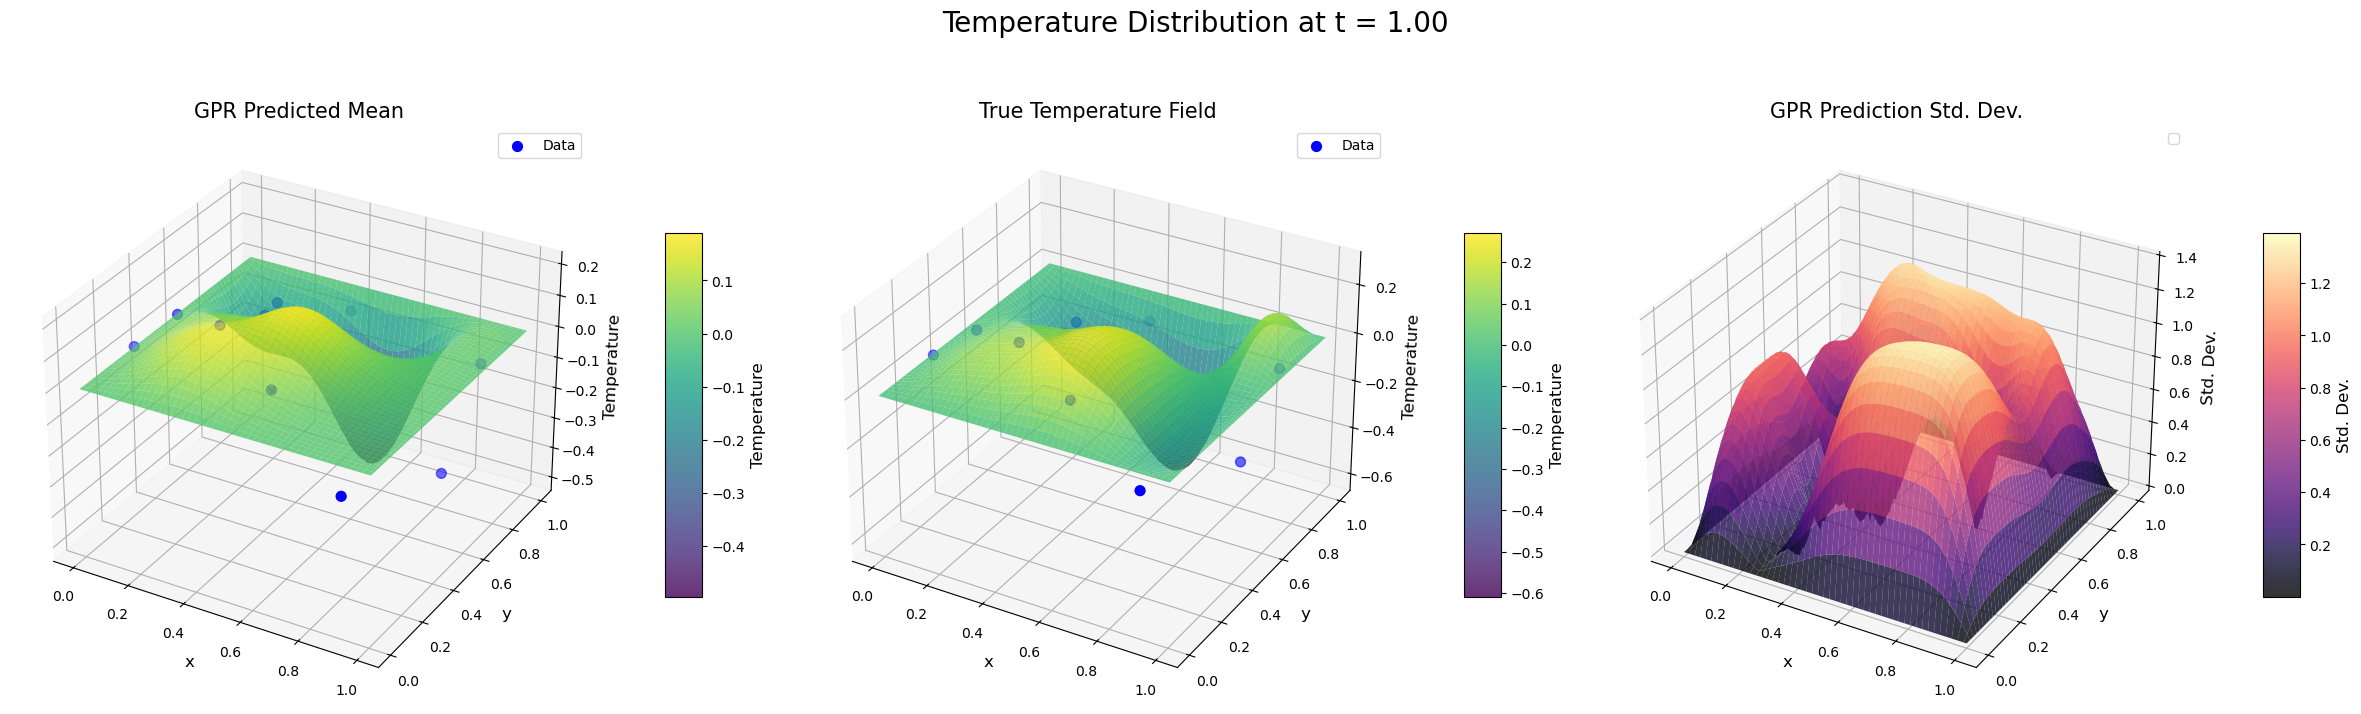

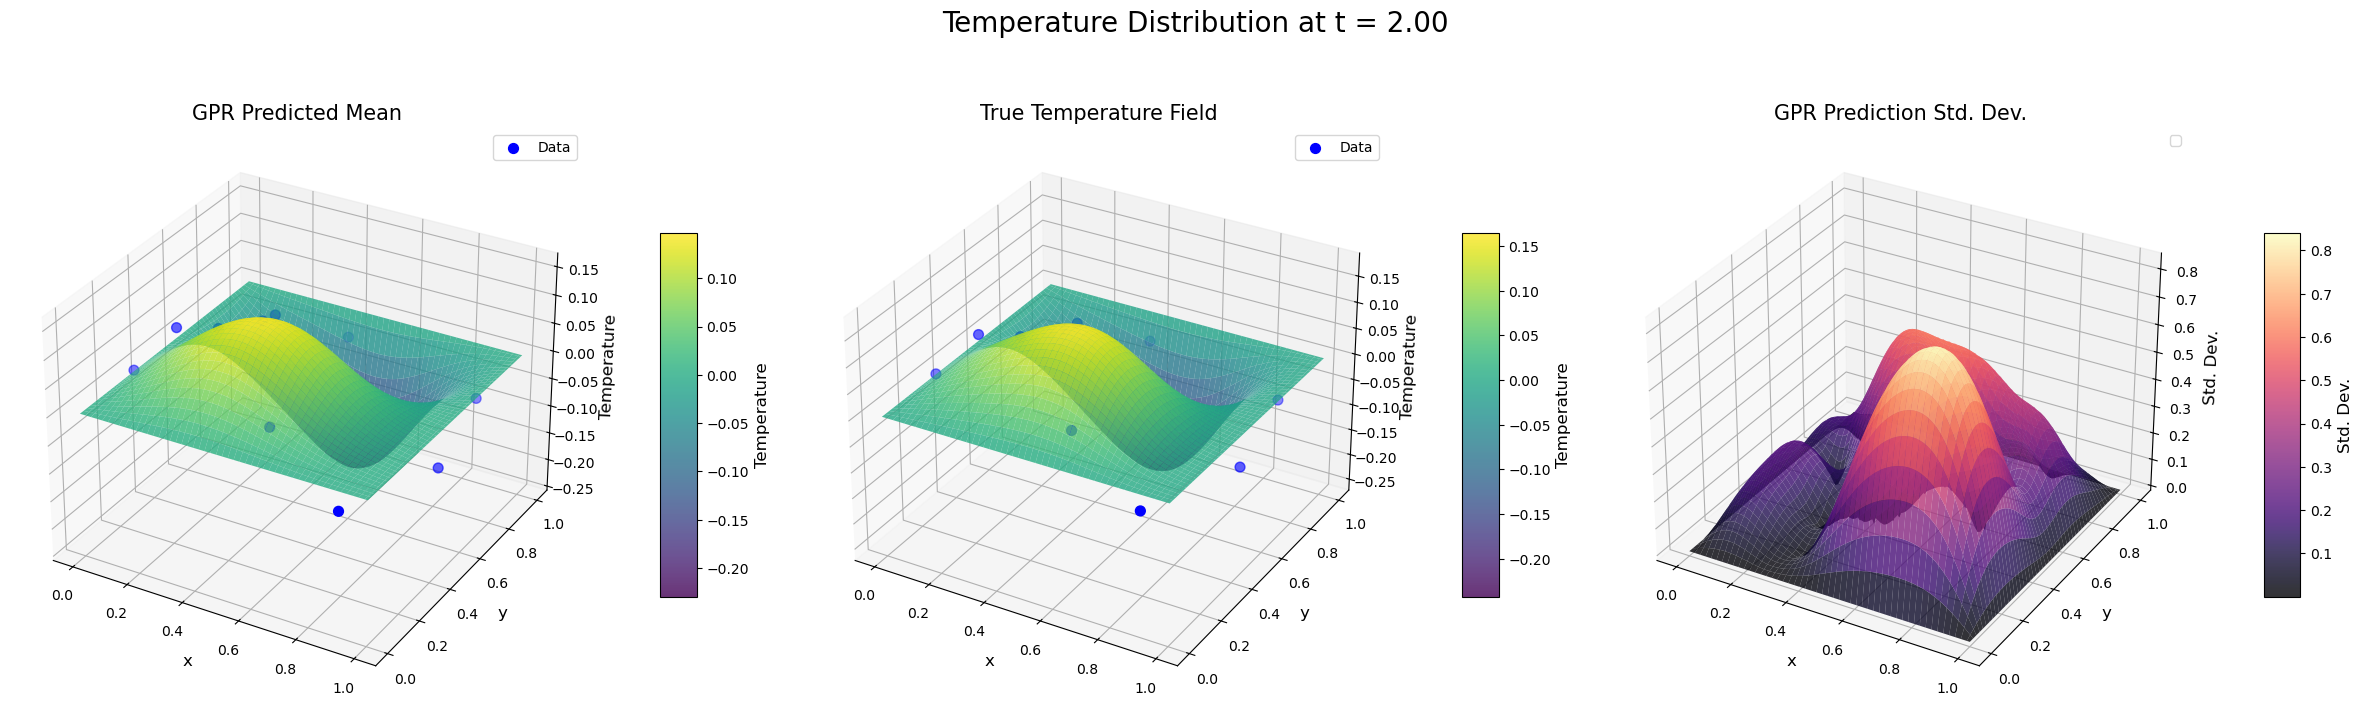

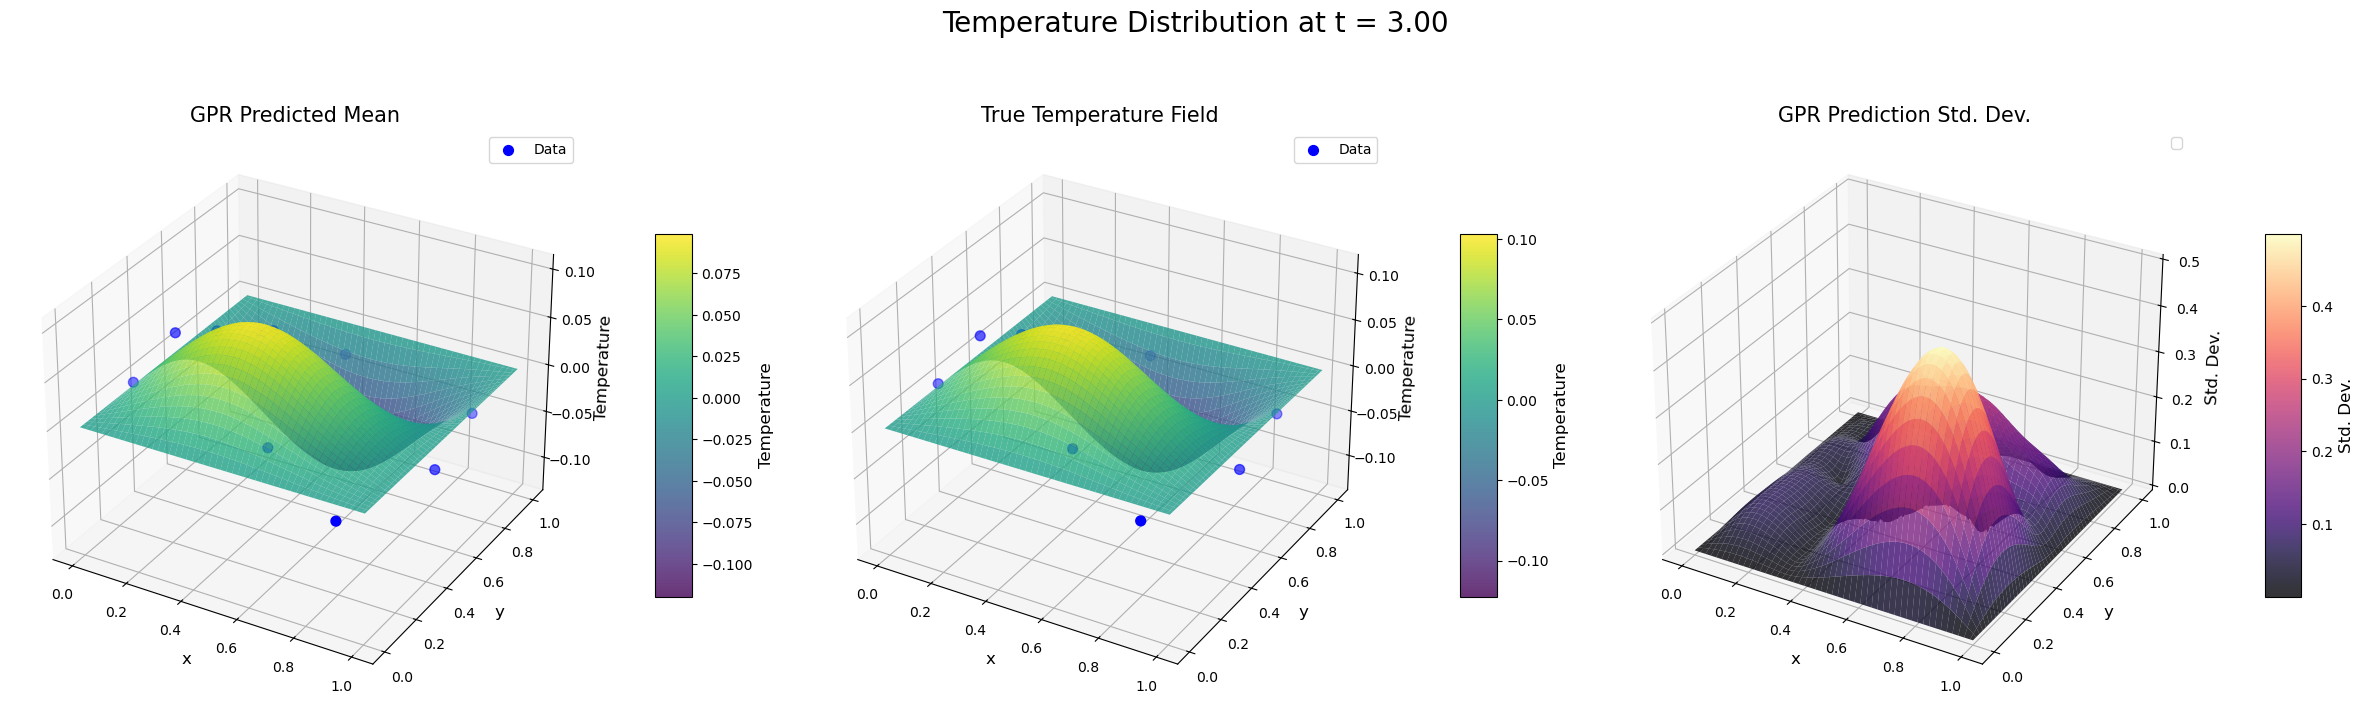

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
rng = np.random.default_rng(1) 

# --- Parameters ---
L = 1.0           # Assume square domain Lx = Ly = L
alpha = 0.01
modes = 10       # Use same number of modes in each direction for simplicity Nn = Nm = N
sigma = 0.01      # Measurement noise
grid_res = 100 # Resolution for plotting
num_meas = 10

# Generate random Fourier coefficients
c_n,c_m = rng.uniform(-1, 1, modes), rng.uniform(-1, 1, modes)

# Define Measurement Points (e.g., 5 points)
rng_measurements = np.random.default_rng(1)
x1_measure = rng_measurements.uniform(0, L, size=num_meas)
x2_measure = rng_measurements.uniform(0, L, size=num_meas)

# Define Prediction Grid
x_plot,y_plot = np.linspace(0, L, grid_res), np.linspace(0, L, grid_res)
X_plot, Y_plot = np.meshgrid(x_plot, y_plot)

# Flatten prediction grid coordinates
x_pred_flat = X_plot.flatten()
y_pred_flat = Y_plot.flatten()

# --- Time Loop for Plotting/Animation ---
time_list = [0, 1.0, 2.0,3.0] # Example times


for time in time_list:
    measured_temps = measure_T(alpha, time, x1_measure, x2_measure, L, c_n, c_m)
    A_inv_diag = inv_covar(time, modes, alpha, L)
    Kbar = data_covar(L, modes, x1_measure, x2_measure, A_inv_diag, sigma, kernel_function)
    Kbar_inv = linalg.inv(Kbar) 

    T_pred_flat = mean_prediction_matrix(
        x_pred_flat, y_pred_flat,
        L,  modes, A_inv_diag,
        Kbar_inv,
        x1_measure, x2_measure,
        measured_temps
    )

    # Reshape the flat prediction array back to the grid shape
    T_pred_grid = T_pred_flat.reshape((grid_res, grid_res))
    print("Prediction complete.")

    # --- Calculate Variance Grid ---
    Var_pred_grid = vectorized_variance(
        x_pred_flat, y_pred_flat,
        L, modes, A_inv_diag,
        Kbar_inv,
        x1_measure, x2_measure,
        grid_res
    )
    Std_dev_grid = np.sqrt(Var_pred_grid)  # Standard deviation is often plotted
    print("Variance calculation complete.")

    T_true_grid = temp_distr_2d(alpha, time, L, x_plot, c_n, c_m)

    # Prepare grid for plotting
    X, Y = np.meshgrid(x_plot, x_plot)
    
    # --- Plotting ---
    print("Plotting...")
    fig = plt.figure(figsize=(24, 8))
    fig.suptitle(f"Temperature Distribution at t = {time:.2f}", size=20)

    # Predicted Mean
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    plot_3d_temperature(
        ax1, X, Y, T_pred_grid.T, 
        x_measure=x1_measure, y_measure=x2_measure, z_measure=measured_temps,
        title="GPR Predicted Mean", xlabel="x", ylabel="y", zlabel="Temperature",
        cmap="viridis", vmin=np.min(T_pred_grid), vmax=np.max(T_pred_grid), scatter_color='b'
    )

    # True Field
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    plot_3d_temperature(
        ax2, X, Y, T_true_grid,
        x_measure=x1_measure, y_measure=x2_measure, z_measure=measured_temps,
        title="True Temperature Field", xlabel="x", ylabel="y", zlabel="Temperature",
        cmap="viridis", vmin=np.min(T_true_grid), vmax=np.max(T_true_grid), scatter_color='b'
    )

    # Standard Deviation
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    plot_3d_temperature(
        ax3, X, Y, Std_dev_grid.T,
        x_measure=None, y_measure=None, z_measure=None,  # No scatter points for Std Dev
        title="GPR Prediction Std. Dev.", xlabel="x", ylabel="y", zlabel="Std. Dev.",
        cmap="magma", vmin=np.min(Std_dev_grid), vmax=np.max(Std_dev_grid), scatter_color=None
    )

    plt.tight_layout()
plt.show()


## Animation:

Starting 3D animation setup...
Processing frame 1/50, time=0.00
Variance calculation complete.
Processing frame 1/50, time=0.00
Variance calculation complete.
Processing frame 2/50, time=0.06
Variance calculation complete.
Processing frame 3/50, time=0.12
Variance calculation complete.
Processing frame 4/50, time=0.18
Variance calculation complete.
Processing frame 5/50, time=0.24
Variance calculation complete.
Processing frame 6/50, time=0.31
Variance calculation complete.
Processing frame 7/50, time=0.37
Variance calculation complete.
Processing frame 8/50, time=0.43
Variance calculation complete.
Processing frame 9/50, time=0.49
Variance calculation complete.
Processing frame 10/50, time=0.55
Variance calculation complete.
Processing frame 11/50, time=0.61
Variance calculation complete.
Processing frame 12/50, time=0.67
Variance calculation complete.
Processing frame 13/50, time=0.73
Variance calculation complete.
Processing frame 14/50, time=0.80
Variance calculation complete.
Proc

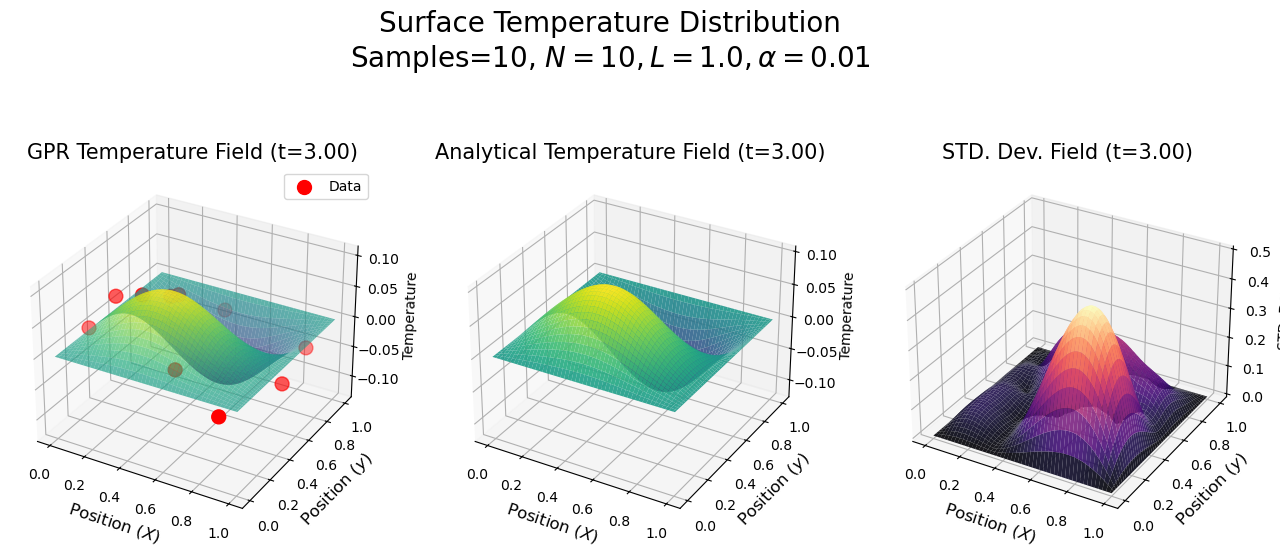

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation,  FFMpegWriter
from scipy import linalg
rng = np.random.default_rng(1)

# --- Parameters ---
L = 1.0           # Assume square domain Lx = Ly = L
alpha = 0.01
modes = 10       # Use same number of modes in each direction for simplicity Nn = Nm = N
sigma = 0.01      # Measurement noise
grid_res = 100 # Resolution for plotting
num_meas = 10

# Generate random Fourier coefficients
c_n,c_m = rng.uniform(-1, 1, modes), rng.uniform(-1, 1, modes)

# Define Measurement Points (e.g., 5 points)
rng_measurements = np.random.default_rng(1)
x1_measure = rng_measurements.uniform(0, L, size=num_meas)
x2_measure = rng_measurements.uniform(0, L, size=num_meas)

# Define Prediction Grid
x_plot,y_plot = np.linspace(0, L, grid_res), np.linspace(0, L, grid_res)
X_plot, Y_plot = np.meshgrid(x_plot, y_plot)

# Flatten prediction grid coordinates
x_pred_flat = X_plot.flatten()
y_pred_flat = Y_plot.flatten()

# --- Animation Function ---
def animate_3d_temperature(time_list):
    """
    Creates and saves an animation of the 3D temperature field evolution.

    Args:
        time_list: A list or array of time points to animate.
    """
    fig = plt.figure(figsize=(16, 7))

    # --- Setup 3D Subplots ---
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    # Adjust the spacing between the subplots
    # plt.subplots_adjust(wspace=0.05)  # Reduce the space between the subplots (default is 0.2)
    z_min, z_max = None, None # To store consistent Z limits
    surf1, surf2, surf3 = None, None, None # To store plot objects (optional but good practice)
    scat1 = None

    print("Starting 3D animation setup...")

    def update(frame):
        nonlocal z_min, z_max, surf1, surf2,surf3, scat1
        time = time_list[frame]
        print(f"Processing frame {frame+1}/{len(time_list)}, time={time:.2f}")

        # --- Calculations (Assuming functions are defined elsewhere) ---
        # Ensure these functions return data with correct shapes
        measured_temps = measure_T(alpha, time, x1_measure, x2_measure, L, c_n, c_m)
        A_inv_diag = inv_covar(time, modes, alpha, L)
        Kbar = data_covar(L, modes, x1_measure, x2_measure, A_inv_diag, sigma, kernel_function)
        Kbar_inv = linalg.inv(Kbar) 

        T_true_grid = temp_distr_2d(alpha, time, L, x_plot, c_n, c_m)

        T_pred_flat = mean_prediction_matrix(
            x_pred_flat, y_pred_flat,
            L,  modes, A_inv_diag,
            Kbar_inv,
            x1_measure, x2_measure,
            measured_temps
        )

        T_pred_grid = T_pred_flat.reshape((grid_res, grid_res))

        Var_pred_grid = vectorized_variance(
            x_pred_flat, y_pred_flat,
            L, modes, A_inv_diag,
            Kbar_inv,
            x1_measure, x2_measure,
            grid_res
        )
        Std_dev_grid = np.sqrt(Var_pred_grid)  # Standard deviation is often plotted
        
        print("Variance calculation complete.")
        # --- Update Plots (Clear and Replot method for 3D) ---

        # 1. Predicted Temperature Plot
        ax1.clear()
        # *** FIX: Use X_plot, Y_plot (2D meshgrid) for plot_surface ***
        surf1 = ax1.plot_surface(X_plot, Y_plot, T_pred_grid.T, cmap='viridis', vmin=z_min, vmax=z_max, alpha=0.7)
        scat1 = ax1.scatter(x1_measure, x2_measure, measured_temps, color='red', s=100, depthshade=True, label='Data')
        ax1.set_title(f"GPR Temperature Field (t={time:.2f})", size=15)
        ax1.set_xlabel(r"Position $(X)$", size=12)
        ax1.set_ylabel(r"Position $(y)$", size=12)
        ax1.set_zlabel("Temperature")
        if z_min is not None and z_max is not None:
            ax1.set_zlim(z_min, z_max) # Apply consistent z-limits
        ax1.legend()

        # 2. True Temperature Plot
        ax2.clear()
        # *** FIX: Use X_plot, Y_plot (2D meshgrid) for plot_surface ***
        surf2 = ax2.plot_surface(X_plot, Y_plot, T_true_grid, cmap='viridis', vmin=z_min, vmax=z_max, alpha=0.9)
        ax2.set_title(f"Analytical Temperature Field (t={time:.2f})", size=15)
        ax2.set_xlabel(r"Position $(X)$", size=12)
        ax2.set_ylabel(r"Position $(y)$", size=12)
        ax2.set_zlabel("Temperature")
        if z_min is not None and z_max is not None:
            ax2.set_zlim(z_min, z_max) # Apply consistent z-limits

        # 2. stdev Plot
        ax3.clear()
        # *** FIX: Use X_plot, Y_plot (2D meshgrid) for plot_surface ***
        surf3 = ax3.plot_surface(X_plot, Y_plot, Std_dev_grid.T, cmap='magma', vmin=z_min, vmax=z_max, alpha=0.9)
        ax3.set_title(f"STD. Dev. Field (t={time:.2f})", size=15)
        ax3.set_xlabel(r"Position $(X)$", size=12)
        ax3.set_ylabel(r"Position $(y)$", size=12)
        ax3.set_zlabel("STD. Dev.")
        if z_min is not None and z_max is not None:
            ax3.set_zlim(z_min, z_max) # Apply consistent z-limits
            
        

        fig.suptitle(f"Surface Temperature Distribution\n"+rf"Samples={num_meas}, $N={modes},L={L},\alpha={alpha}$", size=20)
        # Use tight_layout cautiously with 3D plots, sometimes manual adjustment is better

    # --- Create and Save Animation ---
    ani = FuncAnimation(fig, update, frames=len(time_list), interval=200, blit=False)

    try:
        writer = FFMpegWriter(fps=15, metadata=dict(artist='Generated'), bitrate=1800)
        save_filename = "GPR_3D_Temp_Animation.mp4"
        ani.save(save_filename, writer=writer)
        print(f"Animation saved as {save_filename}")
    except Exception as e:
        print(f"Error saving animation: {e}")
        print("Ensure ffmpeg is installed and accessible in your system PATH.")

    # Display the plot window (optional)
    # plt.show()




# --- Run Animation ---
t_divisions =50; t_max = 3.0
t_array = np.linspace(0, t_max, t_divisions)
animate_3d_temperature(t_array)


## 2D surface plots

Animation saved as SurfaceTemp_animation_2D.mp4


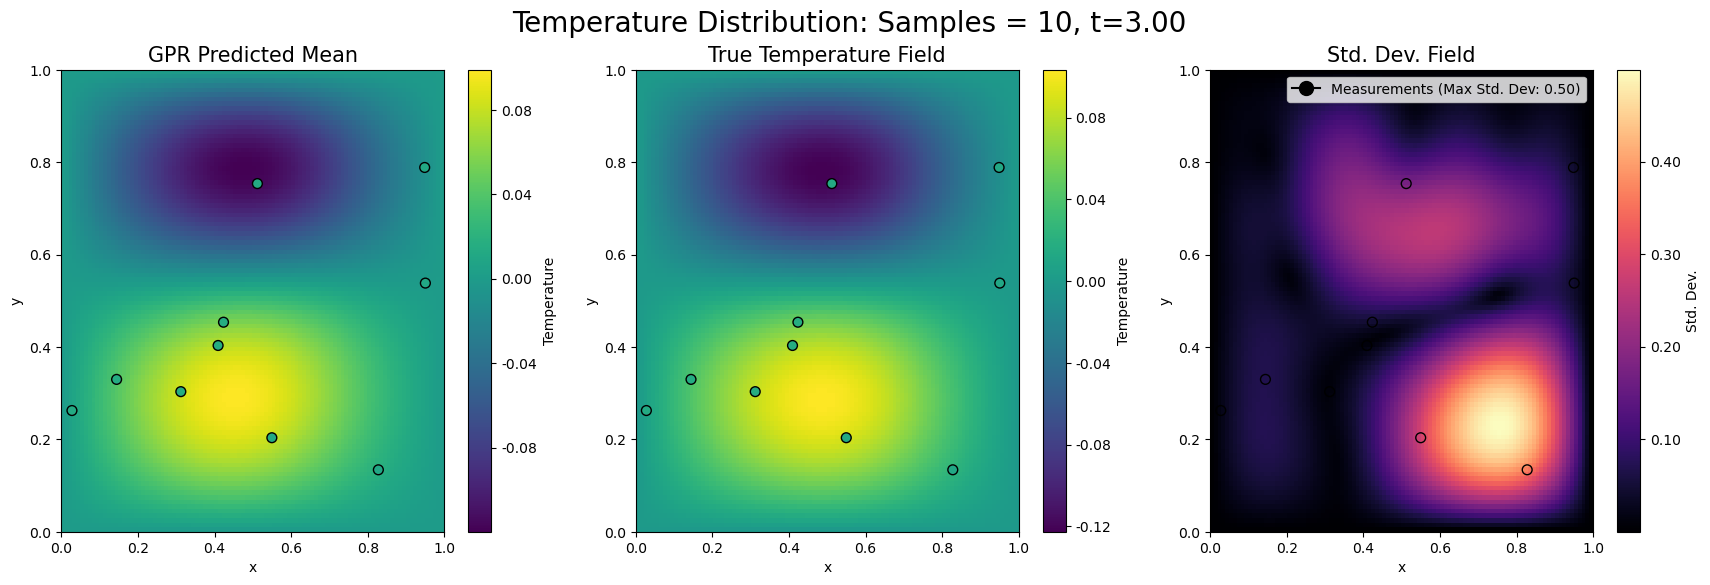

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from scipy import linalg
rng = np.random.default_rng(1)

# --- Parameters ---
L = 1.0           # Assume square domain Lx = Ly = L
alpha = 0.01
modes = 10        # Use same number of modes in each direction for simplicity Nn = Nm = N
sigma = 0.01      # Measurement noise
grid_res = 100     # Resolution for plotting
num_meas = 10

# Generate random Fourier coefficients
c_n, c_m = rng.uniform(-1, 1, modes), rng.uniform(-1, 1, modes)

# Define Measurement Points
rng_measurements = np.random.default_rng(1)
x1_measure = rng_measurements.uniform(0, L, size=num_meas)
x2_measure = rng_measurements.uniform(0, L, size=num_meas)

# Define Prediction Grid
x_plot, y_plot = np.linspace(0, L, grid_res), np.linspace(0, L, grid_res)
X_plot, Y_plot = np.meshgrid(x_plot, y_plot)

# Flatten prediction grid coordinates
x_pred_flat = X_plot.flatten()
y_pred_flat = Y_plot.flatten()

def animate_temperature(time_list):
    fig, axes = plt.subplots(1, 3, figsize=(21, 6))
    num_ticks = 10  # Fixed number of ticks
    fixed_tick_positions = np.linspace(0, 1, num_ticks)  # Fixed tick positions in normalized range [0, 1]

    # Predicted Mean plot
    axes[0].set_title("GPR Predicted Mean", size=15)
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("y")
    im_pred = axes[0].imshow(
        np.zeros((grid_res, grid_res)).T, 
        extent=(0, L, 0, L),
        origin='lower', cmap='viridis', aspect='auto'
    )
    scatter_pred = axes[0].scatter([], [], c=[], cmap='viridis', edgecolor='k', s=50)
    cbar_pred = fig.colorbar(im_pred, ax=axes[0], label="Temperature")
    cbar_pred.set_ticks(fixed_tick_positions)  # Set fixed tick positions

    # True Temperature plot
    axes[1].set_title("True Temperature Field", size=15)
    axes[1].set_xlabel("x")
    axes[1].set_ylabel("y")
    im_true = axes[1].imshow(
        np.zeros((grid_res, grid_res)), 
        extent=(0, L, 0, L),
        origin='lower', cmap='viridis', aspect='auto'
    )
    scatter_true = axes[1].scatter([], [], c=[], cmap='viridis', edgecolor='k', s=50)
    cbar_true = fig.colorbar(im_true, ax=axes[1], label="Temperature")
    cbar_true.set_ticks(fixed_tick_positions)  # Set fixed tick positions

    # Standard Deviation plot
    axes[2].set_title("Std. Dev. Field", size=15)
    axes[2].set_xlabel("x")
    axes[2].set_ylabel("y")
    im_stdev = axes[2].imshow(
        np.zeros((grid_res, grid_res)), 
        extent=(0, L, 0, L),
        origin='lower', cmap='magma', aspect='auto'
    )
    scatter_stdev = axes[2].scatter([], [], c=[], cmap='magma', edgecolor='k', s=50)
    cbar_stdev = fig.colorbar(im_stdev, ax=axes[2], label="Std. Dev.")
    cbar_stdev.set_ticks(fixed_tick_positions)  # Set fixed tick positions

    # Initialize legend
    legend_items = [
        plt.Line2D([0], [0], color='k', marker='o', markersize=10, label="Measurements (Max Std. Dev: N/A)")
    ]

    def update_local(frame):
        time = time_list[frame]
        measured_temps = measure_T(alpha, time, x1_measure, x2_measure, L, c_n, c_m)
        A_inv_diag = inv_covar(time, modes, alpha, L)
        Kbar = data_covar(L, modes, x1_measure, x2_measure, A_inv_diag, sigma, kernel_function)
        Kbar_inv = linalg.inv(Kbar)

        T_true_grid = temp_distr_2d(alpha, time, L, x_plot, c_n, c_m)
        T_pred_flat = mean_prediction_matrix(
            x_pred_flat, y_pred_flat,
            L, modes, A_inv_diag,
            Kbar_inv,
            x1_measure, x2_measure,
            measured_temps
        )
        T_pred_grid = T_pred_flat.reshape((grid_res, grid_res))
        Var_pred_grid = vectorized_variance(
            x_pred_flat, y_pred_flat,
            L, modes, A_inv_diag,
            Kbar_inv,
            x1_measure, x2_measure,
            grid_res
        )
        Std_dev_grid = np.sqrt(Var_pred_grid)

        # Compute ranges for normalization
        pred_min, pred_max = np.min(T_pred_grid), np.max(T_pred_grid)
        true_min, true_max = np.min(T_true_grid), np.max(T_true_grid)
        stdev_min, stdev_max = np.min(Std_dev_grid), np.max(Std_dev_grid)

        # --- Update Predicted Temperature plot ---
        im_pred.set_array(T_pred_grid.T)
        im_pred.set_clim(vmin=pred_min, vmax=pred_max)  # Update color limits
        scatter_pred.set_offsets(np.c_[x1_measure, x2_measure])
        scatter_pred.set_array(measured_temps)
        # Let Matplotlib handle ticks based on new clim
        cbar_pred.locator = MaxNLocator(nbins=6) # Suggest ~5-7 bins for clarity
        cbar_pred.formatter = FormatStrFormatter('%.2f')
        cbar_pred.update_ticks() # IMPORTANT: Tell colorbar to re-draw ticks/labels

        # --- Update True Temperature plot ---
        im_true.set_array(T_true_grid)
        im_true.set_clim(vmin=true_min, vmax=true_max)  # Update color limits
        scatter_true.set_offsets(np.c_[x1_measure, x2_measure])
        scatter_true.set_array(measured_temps)
        # Let Matplotlib handle ticks based on new clim
        cbar_true.locator = MaxNLocator(nbins=6)
        cbar_true.formatter = FormatStrFormatter('%.2f')
        cbar_true.update_ticks() # IMPORTANT

        # --- Update Std. Dev. plot ---
        im_stdev.set_array(Std_dev_grid.T)
        im_stdev.set_clim(vmin=stdev_min, vmax=stdev_max)  # Update color limits
        scatter_stdev.set_offsets(np.c_[x1_measure, x2_measure])
        cbar_stdev.locator = MaxNLocator(nbins=6)
        cbar_stdev.formatter = FormatStrFormatter('%.2f')
        cbar_stdev.update_ticks() # IMPORTANT

        # Update legend with max_stdev
        max_stdev = np.max(Std_dev_grid)
        legend_items[0].set_label(f"Measurements (Max Std. Dev: {max_stdev:.2f})")
        axes[2].legend(handles=legend_items, loc="upper right")

        fig.suptitle(f"Temperature Distribution: Samples = {num_meas}, t={time:.2f}", size=20)
        return im_pred, scatter_pred, im_true, scatter_true, im_stdev, scatter_stdev

    ani = FuncAnimation(fig, update_local, frames=len(time_list), interval=1000, blit=True)
    writer = FFMpegWriter(fps=15, metadata=dict(artist='Hasan'), bitrate=1800)
    ani.save("SurfaceTemp_animation_2D.mp4", writer=writer)
    print("Animation saved as SurfaceTemp_animation_2D.mp4")

# --- Run Animation ---
t_divisions = 50
t_max = 3.0
t_array = np.linspace(0, t_max, t_divisions + 1)
animate_temperature(t_array)
